# Predicting Tropical Cyclone Severity: A CV-Based Approach
#### Using satellite imagery to predict maximum sustained wind speeds of tropical cyclones
#### Data Modeling

In this notebook, we construct and fine-tune a variety of pre-trained `torchvision` models using the `pytorch-lightning` wrapper. All data is available [here](https://www.drivendata.org/competitions/72/predict-wind-speeds/). We draw inspiration from [this notebook](https://github.com/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-benchmark.ipynb).


Andrew McDonald // CSE 881 // April 2021

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
import torchvision.models as models

from abc import abstractmethod
from datetime import datetime
from PIL import Image
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

# nb_mode = "fit"
nb_mode = "eval"
os.environ["TORCH_HOME"] = str(Path.cwd() / "models")
PATH = {
    "metadata": Path.cwd() / "nasa_tropical_storm_competition_csvs",
    "train": Path.cwd() / "nasa_tropical_storm_competition_train_source",
    "test": Path.cwd() / "nasa_tropical_storm_competition_test_source"
}

#### Load Datasets

See data exploration notebook for more on dataset construction and structure.

In [2]:
features = pd.read_csv(PATH["metadata"] / "training_set_features.csv")
labels = pd.read_csv(PATH["metadata"] / "training_set_labels.csv")
data = pd.merge(features, labels, on="Image ID")
data.columns = [s.replace(" ", "_").lower() for s in data.columns]
data["image_path"] = "nasa_tropical_storm_competition_train_source_" + data["image_id"]
data["filename"] = PATH["train"] / data["image_path"] / "image.jpg"
data

,image_id,storm_id,relative_time,ocean,wind_speed,image_path,filename
0,nhe_000,nhe,0,2,34,nasa_tropical_storm_competition_train_source_n...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
1,nhe_001,nhe,1800,2,34,nasa_tropical_storm_competition_train_source_n...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
2,nhe_002,nhe,3600,2,34,nasa_tropical_storm_competition_train_source_n...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
3,nhe_003,nhe,5402,2,33,nasa_tropical_storm_competition_train_source_n...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
4,nhe_004,nhe,9001,2,32,nasa_tropical_storm_competition_train_source_n...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
...,...,...,...,...,...,...,...
70252,yti_071,yti,255601,1,45,nasa_tropical_storm_competition_train_source_y...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
70253,yti_072,yti,259201,1,45,nasa_tropical_storm_competition_train_source_y...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
70254,yti_073,yti,262801,1,45,nasa_tropical_storm_competition_train_source_y...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...
70255,yti_074,yti,266401,1,45,nasa_tropical_storm_competition_train_source_y...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...


#### Build Training / Validation Data

Build train/val split with fixed random seed, then downsample for computational constraints.

In [3]:
full_train, full_val = train_test_split(data, test_size=0.2, random_state=881)
full_train.shape, full_val.shape

((56205, 7), (14052, 7))

In [4]:
train = full_train.sample(n=10000, replace=False, random_state=881)
val = full_val.sample(n=1000, replace=False, random_state=881)
train.shape, val.shape

((10000, 7), (1000, 7))

In [5]:
X_train, X_val = train.drop("wind_speed", axis=1), val.drop("wind_speed", axis=1)
y_train, y_val = train["wind_speed"], val["wind_speed"]

#### Build Testing Data

Downsample test set with fixed random seed for computational constraints.

In [6]:
full_test_features = pd.read_csv(PATH["metadata"] / "test_set_features.csv")
full_test_features.columns = [s.replace(" ", "_").lower() for s in full_test_features.columns]
full_test_labels = pd.read_csv(PATH["metadata"] / "test_set_labels.csv")
full_test_labels.columns = [s.replace(" ", "_").lower() for s in full_test_labels.columns]

In [7]:
test_features = full_test_features.sample(n=1000, replace=False, random_state=881)
test_labels = full_test_labels.loc[test_features.index, :]
display(test_features)
display(test_labels)

,image_id,storm_id,relative_time,ocean
2500,lhc_110,lhc,919800,2
39604,spo_001,spo,1800,1
30053,cwf_028,cwf,64800,1
13027,zsh_001,zsh,1800,2
13540,whs_106,whs,284399,2
...,...,...,...,...
20301,rzk_206,rzk,579601,1
20753,tbs_105,tbs,226802,1
16561,fmv_076,fmv,165600,1
9042,zez_026,zez,57599,2


,image_id,wind_speed
2500,lhc_110,83
39604,spo_001,30
30053,cwf_028,70
13027,zsh_001,26
13540,whs_106,45
...,...,...
20301,rzk_206,25
20753,tbs_105,101
16561,fmv_076,104
9042,zez_026,61


In [8]:
test_features["image_path"] = "nasa_tropical_storm_competition_test_source_" + test_features["image_id"]
test_features["filename"] = PATH["test"] / test_features["image_path"] / "image.jpg"
test_features.head(1)

,image_id,storm_id,relative_time,ocean,image_path,filename
2500,lhc_110,lhc,919800,2,nasa_tropical_storm_competition_test_source_lh...,D:\Documents\MSU\SS21\CSE 881\Project\nasa_tro...


#### Build Torch Dataset Class

Overriding the `torch.utils.data.Dataset` base class will allow us to use the `torch.utils.data.DataLoader` later on. We draw inspiration from [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [9]:
class DatasetTS(Dataset):
    """
    Override the torch Dataset base class to serve tropical storm images on-demand.
    Transform images to shape and normalization expected by pretrained models.
    Implement the __len__ and __getitem__ functions.
    """
    def __init__(self, X, y=None):
        self.X = X
        self.y = y      # optional, not necessary if test set
        # pretrained models expect 224x224 @ given normalization
        # https://discuss.pytorch.org/t/imagenet-pretrained-models-image-dimensions/94649/4
        # https://pytorch.org/vision/stable/models.html
        self.transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        img = self.transform(Image.open(self.X.iloc[i]["filename"]).convert("RGB"))
        img_id = self.X.iloc[i]["image_id"]
        if self.y is not None:
            return {"image_id": img_id, "image": img, "label": self.y.iloc[i]}      # training
        return {"image_id": img_id, "image": img}                                   # testing

#### Build Torch RMSE Class

Override the built-in `MSELoss` class as a `torch.nn.Module` to report RMSE, a more interpretable metric when it comes to wind speeds.

In [10]:
class RMSELoss(nn.Module):
    """
    Override built-in MSELoss to report RMSE, a more interpretable metric.
    """
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_hat, y_true):
        return torch.sqrt(self.mse(y_hat, y_true))

#### Build PyTorch Model with Torch Lightning

Utilize `pytorch-lightning` library to simplify and organize model logic. First, define an abstract base class with pipeline logic, leaving all but model architecture defined. Then, extend base class with specific pretrained model architectures.

Due to computational constraints, we limit consideration to small architectures. In particular, we fine-tune:
- [SqueezeNet 1.1](https://pytorch.org/vision/stable/models.html#torchvision.models.squeezenet1_1) (4.9 mb)
- [ShuffleNet v2 1.0x](https://pytorch.org/vision/stable/models.html#torchvision.models.shufflenet_v2_x1_0) (9.0 mb)
- [ResNet-18](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (45.7 mb, fast to train due to residual connections)

We encourage future GPU-enabled research on larger networks known to perform well, such as [VGG](https://pytorch.org/vision/stable/models.html#id2) or deeper implementations of [ResNet](https://pytorch.org/vision/stable/models.html#id3).

In [11]:
class TSNet(pl.LightningModule):
    """
    Adapt a pretrained torchvision model for use in tropical storm wind severity prediction.
    Extend the pl.LightningModule base class to simplify and organize model logic.
    Abstract class to be overriden by subclass specifying model architecture.
    """
    def __init__(self, hyp):
        super(TSNet, self).__init__()
        self.hyp = hyp

        # set required hyperparameters
        self.X_train = hyp["X_train"]
        self.X_val = hyp["X_val"]
        self.y_train = hyp["y_train"]
        self.y_val = hyp["y_val"]
        self.name = hyp["name"]

        # set optional hyperparameters with default arguments
        self.learning_rate = hyp.get("learning_rate", 3e-4)     # use Alex's favorite: https://twitter.com/karpathy/status/801621764144971776?lang=en
        self.hidden_dim = hyp.get("hidden_dim", 64)             # hidden layer width in FC
        self.dropout = hyp.get("dropout", 0)                    # don't use dropout unless we overfit
        self.max_epochs = hyp.get("max_epochs", 1)              # number of epochs to fine-tune
        self.batch_size = hyp.get("batch_size", 32)             # start here, as per: https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu
        self.num_workers = hyp.get("num_workers", 0)            # default to 0 on windows: https://discuss.pytorch.org/t/errors-when-using-num-workers-0-in-dataloader/97564/4

        # set path where model is saved
        self.output_path = Path.cwd() / hyp.get("output_path", "models") / self.name
        self.output_path.mkdir(exist_ok=True)

        # set up logging
        self.log_path = Path.cwd() / hyp.get("log_path", "logs") / self.name
        self.log_path.mkdir(exist_ok=True)

        # construct datasets and model
        self.train_dataset = DatasetTS(self.X_train, self.y_train)
        self.val_dataset = DatasetTS(self.X_val, self.y_val)
        self.model = self.init_model()

    @abstractmethod
    def init_model(self):
        # to be implemented by subclass defining model architecture
        pass

    def forward(self, img):
        return self.model(img)

    def training_step(self, batch, batch_idx):
        X, y = batch["image"], batch["label"]
        criterion = RMSELoss()
        loss = criterion(y_hat=self.model.train().forward(X).squeeze(),     # use model train mode
                         y_true=y.type(torch.FloatTensor))
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch["image"], batch["label"]
        criterion = RMSELoss()
        loss = criterion(y_hat=self.model.eval().forward(X).squeeze(),      # use model eval mode
                         y_true=y.type(torch.FloatTensor))
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"batch_val_loss": loss}

    def train_dataloader(self):
        return DataLoader(self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size)

    def configure_optimizers(self):
        # use Adam with weight decay as per: https://www.fast.ai/2018/07/02/adam-weight-decay/
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        self.log("avg_epoch_train_loss", avg_train_loss)
        # d = {"avg_epoch_train_loss": avg_train_loss}
        # return {**d, "progress_bar": d, "log": d}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(tuple(output["batch_val_loss"] for output in outputs)).mean()
        self.log("avg_epoch_val_loss", avg_val_loss)
        # d = {"avg_epoch_val_loss": avg_val_loss}
        # return {**d, "progress_bar": d, "log": d}

    def fit(self):
        # see https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=TensorBoardLogger(save_dir=self.log_path),
            log_every_n_steps=self.hyp.get("log_every_n_steps", 5),
            checkpoint_callback=True,
            callbacks=pl.callbacks.ModelCheckpoint(
                dirpath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
            ),
            gradient_clip_val=self.hyp.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hyp.get("val_sanity_checks", 0),
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def predict_wind_speed(self, X_test):
        test_dataset = DatasetTS(X_test)
        test_dataloader = DataLoader(test_dataset, num_workers=self.num_workers, batch_size=self.batch_size)
        wind_speed_df = pd.DataFrame(index=X_test["image_id"], columns=["wind_speed"])

        # predict windspeeds with progress bar wrapper
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            X = batch["image"]
            y_hat = self.eval().forward(X)
            y_hat = y_hat.detach().numpy().squeeze()
            y_hat = np.clip(y_hat, a_min=0, a_max=200)      # don't predict ridiculous wind speeds
            wind_speed_df.loc[batch["image_id"], "wind_speed"] = y_hat

        # cast to float type and return for evaluation
        wind_speed_df["wind_speed"] = wind_speed_df["wind_speed"].astype(float)
        return wind_speed_df

In [12]:
# download pretrained models locally
# save to cwd/models directory as per: https://stackoverflow.com/questions/52628270/is-there-any-way-i-can-download-the-pre-trained-models-available-in-pytorch-to-a
models.resnet18(pretrained=True)
models.squeezenet1_1(pretrained=True)
models.shufflenet_v2_x1_0(pretrained=True)
print("Models Downloaded.")

Models Downloaded.


In [13]:
class TSResNet18(TSNet):
    """
    Extend the TSNet base class for tropical storm wind prediction with a pretrained ResNet18.
    Architectural details here: https://arxiv.org/pdf/1512.03385.pdf.
    """
    def __init__(self, hyp):
        hyp["name"] = "TSResNet18"
        super(TSResNet18, self).__init__(hyp)

    def init_model(self):
        resnet18 = models.resnet18(pretrained=True)
        # drop classifier layer and construct 1-dim output FC
        # see: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
        resnet18.fc = nn.Sequential(
            nn.Linear(512, self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, 1),
        )
        return resnet18

class TSSqueezeNet(TSNet):
    """
    Extend the TSNet base class for tropical storm wind prediction with a pretrained SqueezeNet.
    Architectural details here: https://arxiv.org/pdf/1602.07360.pdf.
    """
    def __init__(self, hyp):
        hyp["name"] = "TSSqueezeNet"
        super(TSSqueezeNet, self).__init__(hyp)

    def init_model(self):
        squeezenet = models.squeezenet1_1(pretrained=True)
        # drop classifier layer and construct 1-dim output FC
        # see: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
        squeezenet.classifier = nn.Sequential(
            # unlike other models used, squeezenet's classifier includes the
            # last conv layer before linking to FC
            nn.Dropout(self.dropout),
            nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        return squeezenet

class TSShuffleNet(TSNet):
    """
    Extend the TSNet base class for tropical storm wind prediction with a pretrained ShuffleNet.
    Architectural details here: https://arxiv.org/pdf/1807.11164.pdf.
    """
    def __init__(self, hyp):
        hyp["name"] = "TSShuffleNet"
        super(TSShuffleNet, self).__init__(hyp)

    def init_model(self):
        shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        # drop classifier layer and construct 1-dim output FC
        # see: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
        shufflenet.fc = nn.Sequential(
            nn.Linear(1024, self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, 1),
        )
        return shufflenet


#### Fit Models to Subsampled Training and Validation

Only fit models when `nb_mode == "fit"`.

In [14]:
hyp = {
    "X_train": X_train,
    "X_val": X_val,
    "y_train": y_train,
    "y_val": y_val,
    "max_epochs": 1,
}


In [15]:
if nb_mode == "fit":
    ts_resnet18 = TSResNet18(hyp)
    ts_resnet18.fit()

    # save in case checkpointing fails
    torch.save(ts_resnet18.state_dict(), Path.cwd() / "models" / "TSResNet18" / f"{time.strftime('%Y_%m_%d_%H_%M_%S')}.pth")

In [16]:
if nb_mode == "fit":
    ts_squeezenet = TSSqueezeNet(hyp)
    ts_squeezenet.fit()

    # save in case checkpointing fails
    torch.save(ts_squeezenet.state_dict(), Path.cwd() / "models" / "TSSqueezeNet" / f"{time.strftime('%Y_%m_%d_%H_%M_%S')}.pth")

In [17]:
if nb_mode == "fit":
    ts_shufflenet = TSShuffleNet(hyp)
    ts_shufflenet.fit()

    # save in case checkpointing fails
    torch.save(ts_shufflenet.state_dict(), Path.cwd() / "models" / "TSShuffleNet" / f"{time.strftime('%Y_%m_%d_%H_%M_%S')}.pth")

#### Load Models from Previous Training

Only load models when `nb_mode == "eval"`.

In [18]:
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

In [19]:
if nb_mode == "eval":
    best_ts_resnet18 = "epoch=0-step=312.ckpt"
    ts_resnet18_ckpt = torch.load(Path.cwd() / "models" / "TSResNet18" / best_ts_resnet18)
    ts_resnet18 = weights_update(model=TSResNet18(hyp), checkpoint=ts_resnet18_ckpt)

In [20]:
if nb_mode == "eval":
    best_ts_squeezenet = "epoch=1-step=625.ckpt"
    ts_squeezenet_ckpt = torch.load(Path.cwd() / "models" / "TSSqueezeNet" / best_ts_squeezenet)
    ts_squeezenet = weights_update(model=TSSqueezeNet(hyp), checkpoint=ts_squeezenet_ckpt)

In [21]:
if nb_mode == "eval":
    best_ts_shufflenet = "epoch=1-step=625.ckpt"
    ts_shufflenet_ckpt = torch.load(Path.cwd() / "models" / "TSShuffleNet" / best_ts_shufflenet)
    ts_shufflenet = weights_update(model=TSShuffleNet(hyp), checkpoint=ts_shufflenet_ckpt)

#### Evaluate Models

In [22]:
y_ts_resnet18 = ts_resnet18.predict_wind_speed(test_features)

  0%|          | 0/32 [00:00<?, ?it/s]

In [23]:
y_ts_squeezenet = ts_squeezenet.predict_wind_speed(test_features)

  0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
y_ts_shufflenet = ts_shufflenet.predict_wind_speed(test_features)

  0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
model_stats = []
model_predictions = [("TSResNet18", y_ts_resnet18),
                     ("TSSqueezeNet", y_ts_squeezenet),
                     ("TSShuffleNet", y_ts_shufflenet)]

for name, y_hat in model_predictions:
    rmse = mean_squared_error(y_hat["wind_speed"], test_labels["wind_speed"], squared=False)
    mae = mean_absolute_error(y_hat["wind_speed"], test_labels["wind_speed"])
    rho = pearsonr(y_hat["wind_speed"], test_labels["wind_speed"])[0]

    model_stats.append({
        "name": name, "rmse": rmse, "mae": mae, "pearsonr": rho,
        **pd.DataFrame(y_hat).describe()["wind_speed"].to_dict()        # get distribution stats
    })

    print(f"{name}:")
    print(f"\tRMSE     = {rmse}")
    print(f"\tMAE      = {mae}")
    print(f"\tPearsonR = {rho}")

TSResNet18:
	RMSE     = 11.85512456047676
	MAE      = 8.466182781219482
	PearsonR = 0.8751599884576547
TSSqueezeNet:
	RMSE     = 11.780575821612507
	MAE      = 8.22048169517517
	PearsonR = 0.8794337831098971
TSShuffleNet:
	RMSE     = 11.685615915688183
	MAE      = 8.350372329711915
	PearsonR = 0.8702519982151286


In [26]:
model_stats_df = pd.DataFrame(model_stats).T
model_stats_df.to_csv(Path.cwd() / "logs" / f"model_stats_{time.strftime('%Y_%m_%d_%H_%M_%S')}.csv")
model_stats_df

,0,1,2
name,TSResNet18,TSSqueezeNet,TSShuffleNet
rmse,11.855125,11.780576,11.685616
mae,8.466183,8.220482,8.350372
pearsonr,0.87516,0.879434,0.870252
count,1000.0,1000.0,1000.0
mean,42.05335,42.147305,43.984505
std,21.077466,18.716322,19.071808
min,21.464493,20.189493,18.159658
25%,27.265583,28.68371,30.949636
50%,35.270489,36.191402,37.58699


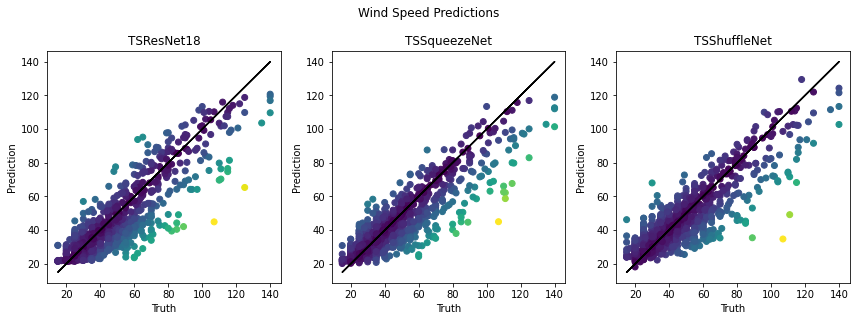

In [29]:
fig, ax = plt.subplots(1, len(model_predictions), figsize=(12, 4.5))
for i, (name, y_hat) in enumerate(model_predictions):
    y, yh = test_labels["wind_speed"], y_hat["wind_speed"]
    ax[i].scatter(y, yh, c=((y.ravel() - yh.ravel())**2)**0.5)
    ax[i].plot(y, y, c="k")
    ax[i].set_xlabel("Truth")
    ax[i].set_ylabel("Prediction")
    ax[i].set_title(name)
fig.suptitle(f"Wind Speed Predictions")

fig.tight_layout()
fig.savefig(Path.cwd() / "logs" / f"model_performance_{time.strftime('%Y_%m_%d_%H_%M_%S')}.png")
plt.show()
